In [4]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

def DFT_slow(x):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

In [5]:
x = np.random.random(1024)
np.allclose(DFT_slow(x), np.fft.fft(x))

True

In [6]:
%timeit DFT_slow(x)
%timeit np.fft.fft(x)

90.7 ms ± 3.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.6 µs ± 9.46 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [7]:
def FFT(x):
    """A recursive implementation of the 1D Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    
    if N % 2 > 0:
        raise ValueError("size of x must be a power of 2")
    elif N <= 32:  # this cutoff should be optimized
        return DFT_slow(x)
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + factor[:N // 2] * X_odd,
                               X_even + factor[N // 2:] * X_odd])

In [8]:
x = np.random.random(1024)
np.allclose(FFT(x), np.fft.fft(x))

True

In [9]:
%timeit DFT_slow(x)
%timeit FFT(x)
%timeit np.fft.fft(x)

92.8 ms ± 4.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.92 ms ± 4.97 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.53 µs ± 26 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:

@jit
def FFT_vectorized(x):
    """A vectorized, non-recursive version of the Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]

    if np.log2(N) % 1 > 0:
        raise ValueError("size of x must be a power of 2")

    # N_min here is equivalent to the stopping condition above,
    # and should be a power of 2
    N_min = min(N, 32)
    
    # Perform an O[N^2] DFT on all length-N_min sub-problems at once
    n = np.arange(N_min)
    k = n[:, None]
    M = np.exp(-2j * np.pi * n * k / N_min)
    X = np.dot(M, x.reshape((N_min, -1)))

    # build-up each level of the recursive calculation all at once
    while X.shape[0] < N:
        X_even = X[:, :X.shape[1] // 2]
        X_odd = X[:, X.shape[1] // 2:]
        factor = np.exp(-1j * np.pi * np.arange(X.shape[0])
                        / X.shape[0])[:, None]
        X = np.vstack([X_even + factor * X_odd,
                       X_even - factor * X_odd])

    return X.ravel()

In [11]:
x = np.random.random(1024)
np.allclose(FFT_vectorized(x), np.fft.fft(x))

True

In [12]:
x = np.random.random(1024 * 16)
%timeit FFT(x)
%timeit FFT_vectorized(x)
%timeit np.fft.fft(x)

50.9 ms ± 90 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.78 ms ± 91.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
54.9 µs ± 955 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [13]:
def gauss(x, y, x0=0, y0=0):
    return np.sin(x-x0) * np.sin(y-y0) # 1/np.sqrt(np.pi) * np.exp(-0.5*((x-x0)**2+(y-y0)**2))

In [14]:
@jit
def FFT_vectorized_img(x):
    """A vectorized, non-recursive version of the Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float) + 0j
    N = x.shape[0]

    if np.log2(N) % 1 > 0:
        raise ValueError("size of x must be a power of 2")

    # N_min here is equivalent to the stopping condition above,
    # and should be a power of 2
    #N_min = min(N, 32)
    N_min = N
    
    # Perform an O[N^2] DFT on all length-N_min sub-problems at once
    n = np.arange(N_min)
    k = n[:, None]
    M = np.exp(-2j * np.pi * n * k / N_min) + 0j
    X = np.dot(M, x.reshape((N_min, -1))) + 0j

    # build-up each level of the recursive calculation all at once
    while X.shape[0] < N:
        X_even = X[:, :X.shape[1] / 2]
        X_odd = X[:, X.shape[1] / 2:]
        factor = np.exp(-1j * np.pi * np.arange(X.shape[0])
                        / X.shape[0])[:, None]
        X = np.vstack([X_even + factor * X_odd,
                       X_even - factor * X_odd])

    return X.ravel()

In [24]:
def IFFT_vectorized(x):
    """A vectorized, non-recursive version of the Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float) + 0j
    N = x.shape[0]

    if np.log2(N) % 1 > 0:
        raise ValueError("size of x must be a power of 2")

    # N_min here is equivalent to the stopping condition above,
    # and should be a power of 2
    #N_min = min(N, 32)
    N_min = N
    
    # Perform an O[N^2] DFT on all length-N_min sub-problems at once
    k = np.arange(N_min)
    n = k[:, None]
    M = np.exp(2j * np.pi * n * k / N_min) + 0j
    X = np.dot(M, x.reshape((N_min, -1))) + 0j

    # build-up each level of the recursive calculation all at once
    while X.shape[0] < N:
        X_even = X[:, :X.shape[1] / 2]
        X_odd = X[:, X.shape[1] / 2:]
        factor = np.exp(1j * np.pi * np.arange(X.shape[0])
                        / X.shape[0])[:, None]
        X = np.vstack([X_even + factor * X_odd,
                       X_even - factor * X_odd])

    return 1//N * X.ravel()

In [25]:
@jit
def fft_2d(psi) :
    N_x = psi.shape[0]
    N_y = psi.shape[1]
    
    psi_hat = np.zeros((N_x, N_y)) + 0j
    psi_hat_1 = np.zeros((N_x, N_y)) + 0j
    #opti = np.zeros((N_x, N_y))
    
    for k in range (N_x):
        psi_hat[k,:] = FFT_vectorized_img(psi[k,:])
    # psi_hat[:,:] = FFT_vectorized_img(psi[:,:])
    
    for p in range (N_y):
        psi_hat_1[:,p] = FFT_vectorized_img(psi_hat[:,p])
    # psi_hat_1[:,:] = FFT_vectorized_img(psi_hat[:,:])
    
    return psi_hat_1
    

In [26]:
@jit
def ifft_2d(psi):
    N_x = psi.shape[0]
    N_y = psi.shape[1]
    
    psi_hat = np.zeros((N_x, N_y)) + 0j
    psi_hat_1 = np.zeros((N_x, N_y)) + 0j
    #opti = np.zeros((N_x, N_y))
    
    for k in range (N_x):
        psi_hat[:,k] = IFFT_vectorized(psi[:,k])
    # psi_hat[:,:] = FFT_vectorized_img(psi[:,:])
    
    for p in range (N_y):
        psi_hat_1[p,:] = IFFT_vectorized(psi_hat[p,:])
    # psi_hat_1[:,:] = FFT_vectorized_img(psi_hat[:,:])
    
    return psi_hat_1

C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


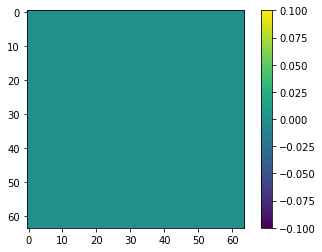

In [27]:
X = 64
Y = 64
a = 10
x = np.linspace(-a,a, X)
y = np.linspace(-a,a, Y)
xx, yy = np.meshgrid(x, y, indexing='ij')
psi = gauss(xx, yy) + (0+0j)
psi_hat = fft_2d(psi)
psi1 = ifft_2d(psi_hat)
np.allclose(psi_hat, np.fft.fft(psi))
plt.imshow(np.abs(psi1))
plt.colorbar()
plt.show()

TypeError: Image data cannot be converted to float

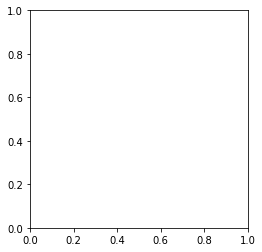

In [27]:
psi_hat1 = np.fft.fft2(psi)
plt.imshow()
plt.colorbar()
plt.show()

In [73]:
%timeit fft_2d(psi)
%timeit np.fft.fft2(psi)

C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


48.4 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
25 µs ± 499 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
